In [1]:
import pandas as pd
import re
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import gzip
from gensim.models import KeyedVectors

c:\Users\hp\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Sandy_Hurricane Dataset

In [5]:
data = pd.read_csv('2013_Boston_Bombings-ontopic_offtopic.csv')

In [6]:
data.head()

,tweet id,tweet,label
0,'325208201740029952',Funny how I got twenty minutes of sleep last n...,off-topic
1,'325301650791215106',I just wanna go outside,off-topic
2,'325182966332530688',This is fucking crazy. Suspect # 2 has like 2 ...,on-topic
3,'324654539850539009',"@J_Adams91 oops, someone doesn't like to be to...",off-topic
4,'323630018536275968',Let me love you @GavinQuin you know who else too,off-topic


In [7]:
data.shape

(10012, 3)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10012 entries, 0 to 10011
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet id  10012 non-null  object
 1   tweet     10012 non-null  object
 2   label     10012 non-null  object
dtypes: object(3)
memory usage: 234.8+ KB


In [9]:
data.isnull().sum()

tweet id    0
tweet       0
label       0
dtype: int64

In [10]:
data['label'].value_counts()

on-topic     5648
off-topic    4364
Name: label, dtype: int64

<b>PREPROCESSING</b>

In [9]:
punctuations = '!"#$%&()*+,-./:;?@[]^_`{|}~\''
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    # Remove mentions
    text = re.sub(r'@[^\s]+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove "RT" (Retweet)
    text = re.sub(r'\bRT\b', '', text, flags=re.IGNORECASE)
    text =re.sub(r'<.*?>',' ',text) #removal of html tags
    text = re.sub('[^a-zA-Z]',' ',text) # filtering out miscellaneous text.
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    text = text.split()
    # Stem words
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    # Remove stopwords and len<2
    text = [word for word in text if len(word)>2]
    # Join the words back into a single string
    text = ' '.join(text)
    # Remove punctuations
    for p in punctuations:
        text = text.replace(p, " ")
    # Stripping the end parts
    text = text.strip()
    return text

In [10]:
data['cleaned_tweet'] = data['tweet'].apply(preprocess)

In [11]:
data.head()

,tweet id,tweet,label,cleaned_tweet
0,'325208201740029952',Funny how I got twenty minutes of sleep last n...,off-topic,funni got twenti minut sleep last night funni ...
1,'325301650791215106',I just wanna go outside,off-topic,wanna outsid
2,'325182966332530688',This is fucking crazy. Suspect # 2 has like 2 ...,on-topic,fuck crazi suspect like hour max
3,'324654539850539009',"@J_Adams91 oops, someone doesn't like to be to...",off-topic,oop someon like told lie punk
4,'323630018536275968',Let me love you @GavinQuin you know who else too,off-topic,let love know els


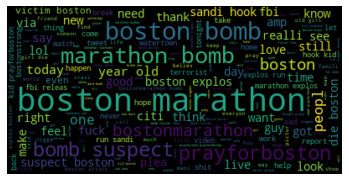

In [14]:
wc = WordCloud(background_color='black')
wc.generate(' '.join(data['cleaned_tweet']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [15]:
def top_ngrams(data,n,grams):
    '''
    Input:- Data: Input Data
            n   : Number of top n-words
            grams:Type of N-grams. 1-> Unigram  2-> Bigram  3->Trigram
            
    Output: Word Frequency of top  n words
    
    '''
    if grams == 1:
        count_vec = CountVectorizer(ngram_range=(1,1)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    elif grams == 2:
        count_vec = CountVectorizer(ngram_range=(2,2)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word,add_words[0,idx]) for word,idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    elif grams == 3:
        count_vec = CountVectorizer(ngram_range=(3,3)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word,add_words[0,idx]) for word,idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)

    return word_freq[:n]

In [16]:
common_words_uni = top_ngrams(data["cleaned_tweet"],20,1)
common_words_bi = top_ngrams(data["cleaned_tweet"],20,2)
common_words_tri = top_ngrams(data["cleaned_tweet"],20,3)
common_words_uni_df = pd.DataFrame(common_words_uni,columns=['word','freq'])
common_words_bi_df = pd.DataFrame(common_words_bi,columns=['word','freq'])
common_words_tri_df = pd.DataFrame(common_words_tri,columns=['word','freq'])

C:\Users\hp\AppData\Local\Temp\ipykernel_21684\2581377941.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(rotation=90,labels=common_words_uni_df["word"],fontsize=10)
C:\Users\hp\AppData\Local\Temp\ipykernel_21684\2581377941.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(rotation=90,labels=common_words_bi_df["word"],fontsize=10)
C:\Users\hp\AppData\Local\Temp\ipykernel_21684\2581377941.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(rotation=90,labels=common_words_tri_df["word"],fontsize=10)


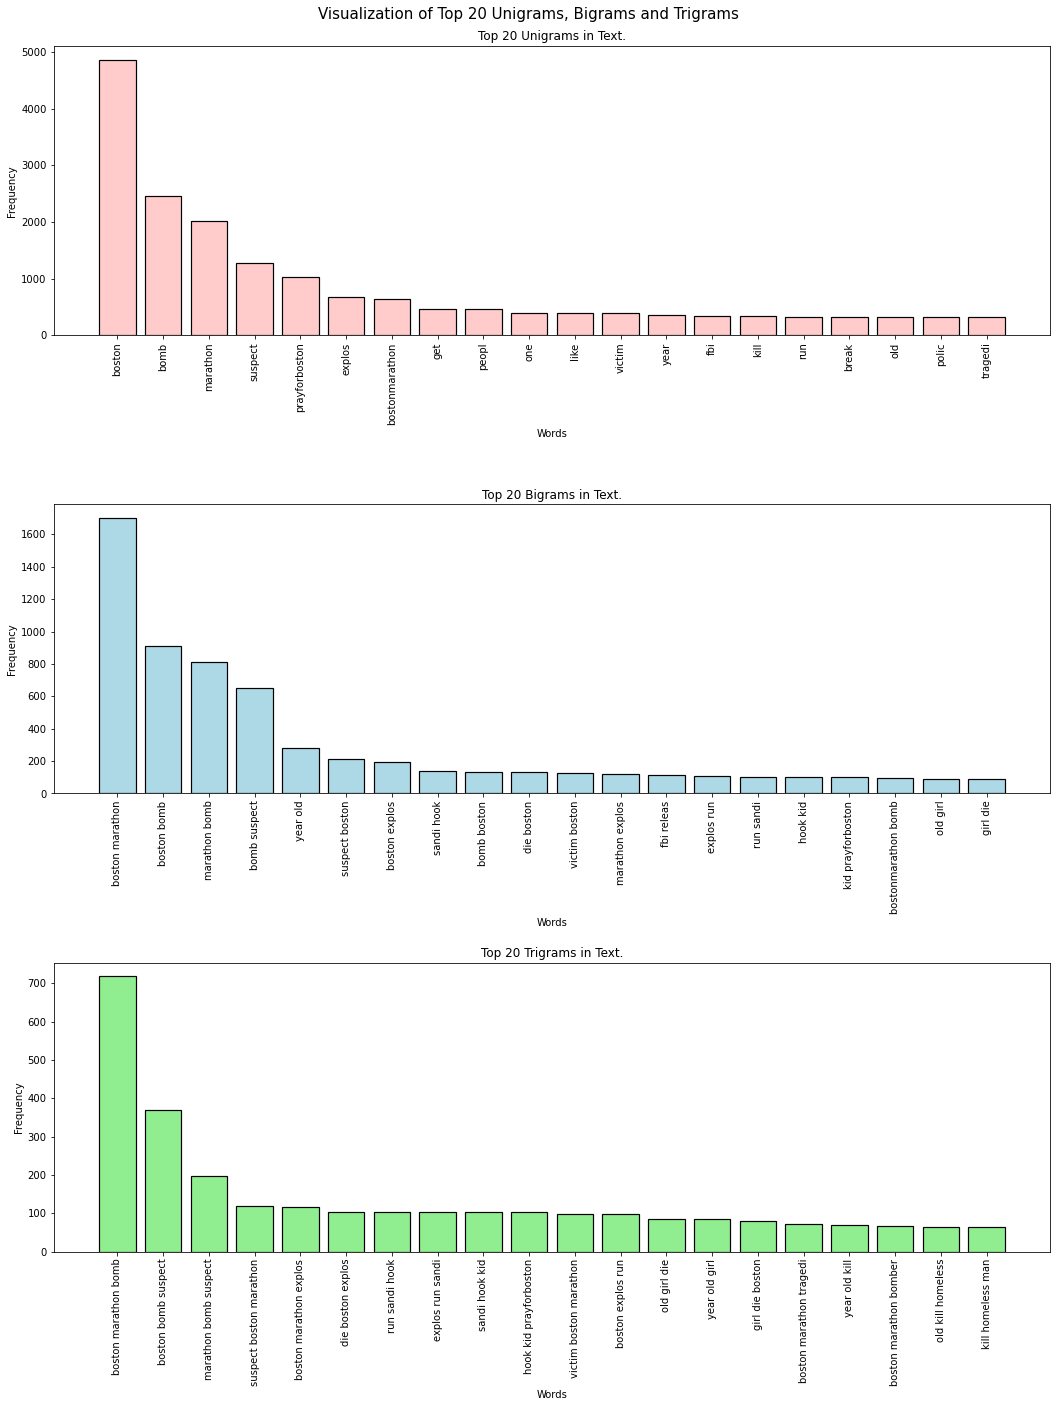

In [17]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,20))
ax1.bar(common_words_uni_df["word"],common_words_uni_df["freq"],color="#FFCCCB",edgecolor='black', linewidth=1.2)
ax1.set_title("Top 20 Unigrams in Text.")
ax1.set_xlabel("Words")
ax1.set_ylabel("Frequency")
ax1.set_xticklabels(rotation=90,labels=common_words_uni_df["word"],fontsize=10)  

ax2.bar(common_words_bi_df["word"],common_words_bi_df["freq"],color="lightblue",edgecolor='black', linewidth=1.2)
ax2.set_title("Top 20 Bigrams in Text.")
ax2.set_xlabel("Words")
ax2.set_ylabel("Frequency")
ax2.set_xticklabels(rotation=90,labels=common_words_bi_df["word"],fontsize=10)

ax3.bar(common_words_tri_df["word"],common_words_tri_df["freq"] ,color="lightgreen",edgecolor='black', linewidth=1.2)
ax3.set_title("Top 20 Trigrams in Text.")
ax3.set_xlabel("Words")
ax3.set_ylabel("Frequency")
ax3.set_xticklabels(rotation=90,labels=common_words_tri_df["word"],fontsize=10) 
plt.suptitle("Visualization of Top 20 Unigrams, Bigrams and Trigrams",fontsize="15")
plt.tight_layout(pad=1.85)
plt.show()

In [12]:
encoder = LabelEncoder()
data['label'] = encoder.fit_transform(data['label'])

In [13]:
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_mapping)

{'off-topic': 0, 'on-topic': 1}


In [14]:
def encoding(train_data,bow,tf_idf):
    '''
    Input : Data to be encoded and choice of encoding.
    Output : Desired Encoding.
    
    '''
    if bow==True: 
        cv = CountVectorizer(ngram_range=(1, 1))
        cv_df = cv.fit_transform(train_data).toarray()
        vectorized_df = pd.DataFrame(cv_df,columns=cv.get_feature_names())
        
    elif tf_idf==True:
        
        tfidf = TfidfVectorizer(
            ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1)    
        tf_df = tfidf.fit_transform(train_data).toarray()
        vectorized_df = pd.DataFrame(tf_df,columns=tfidf.get_feature_names())
        
    return vectorized_df

In [15]:
x_bow = encoding(data["cleaned_tweet"],bow=True,tf_idf=False)

c:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
y = data["label"]

In [17]:
y_final = np.array(y) # Converting y to array

In [18]:
x_bow.shape,y_final.shape

((10012, 8105), (10012,))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x_bow, y_final, test_size=0.2, random_state=42, stratify = y_final)

<b>Classification using BoW</b>
1. SVM

In [20]:
svm_bow = SVC(kernel='linear')
svm_bow.fit(X_train, y_train)
y_pred_b1 = svm_bow.predict(X_test)

In [21]:
accuracy_b1 = accuracy_score(y_test, y_pred_b1)
print(f"Accuracy: {accuracy_b1:.2f}")

Accuracy: 0.93


In [22]:
report = classification_report(y_test, y_pred_b1)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       873
           1       0.94      0.94      0.94      1130

    accuracy                           0.93      2003
   macro avg       0.93      0.93      0.93      2003
weighted avg       0.93      0.93      0.93      2003



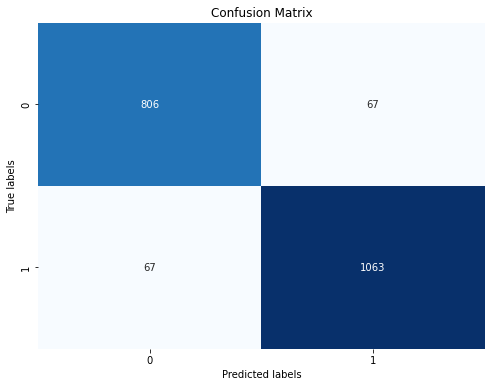

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred_b1)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

2. KNN

In [24]:
knn_bow = KNeighborsClassifier(n_neighbors=40)
knn_bow.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=40)

In [25]:
y_pred_b2 = knn_bow.predict(X_test)

c:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [26]:
accuracy_b2 = accuracy_score(y_test, y_pred_b2)
print(f"Accuracy: {accuracy_b2:.2f}")

Accuracy: 0.75


In [27]:
report = classification_report(y_test, y_pred_b2)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.99      0.78       873
           1       0.98      0.57      0.72      1130

    accuracy                           0.75      2003
   macro avg       0.81      0.78      0.75      2003
weighted avg       0.83      0.75      0.74      2003



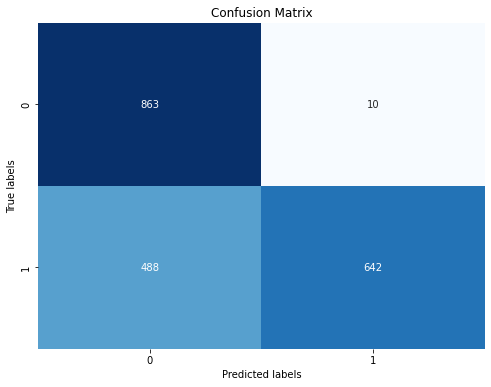

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred_b2)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

3. Naive Bayes

In [29]:
nb_bow = BernoulliNB()
nb_bow.fit(X_train, y_train)

BernoulliNB()

In [30]:
y_pred_b3 = nb_bow.predict(X_test)

In [31]:
accuracy_b3 = accuracy_score(y_test, y_pred_b3)
print(f"Accuracy: {accuracy_b3:.2f}")

Accuracy: 0.92


In [32]:
report = classification_report(y_test, y_pred_b3)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       873
           1       0.94      0.92      0.93      1130

    accuracy                           0.92      2003
   macro avg       0.92      0.92      0.92      2003
weighted avg       0.92      0.92      0.92      2003



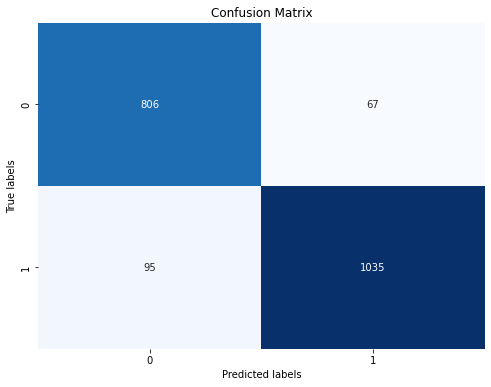

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred_b3)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

4. Decision Tree

In [34]:
tree_bow = DecisionTreeClassifier()
tree_bow.fit(X_train, y_train)

DecisionTreeClassifier()

In [35]:
y_pred_b4 = tree_bow.predict(X_test)

In [36]:
accuracy_b4 = accuracy_score(y_test, y_pred_b4)
print(f"Accuracy: {accuracy_b4:.2f}")

Accuracy: 0.93


In [37]:
report = classification_report(y_test, y_pred_b4)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       873
           1       0.93      0.94      0.94      1130

    accuracy                           0.93      2003
   macro avg       0.93      0.93      0.93      2003
weighted avg       0.93      0.93      0.93      2003



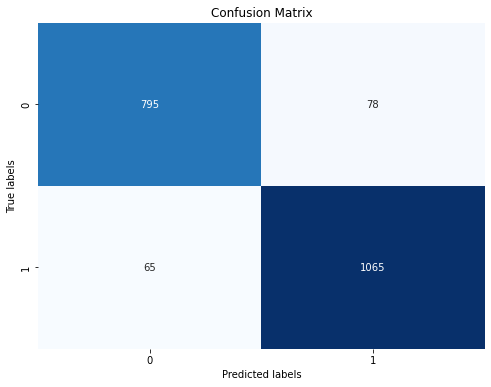

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred_b4)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Random Forest

In [39]:
rf_bow = RandomForestClassifier()
rf_bow.fit(X_train, y_train)

RandomForestClassifier()

In [40]:
y_pred_b5 = rf_bow.predict(X_test)

In [41]:
accuracy_b5 = accuracy_score(y_test, y_pred_b5)
print(f"Accuracy: {accuracy_b5:.2f}")

Accuracy: 0.94


In [42]:
report = classification_report(y_test, y_pred_b5)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       873
           1       0.95      0.95      0.95      1130

    accuracy                           0.94      2003
   macro avg       0.94      0.94      0.94      2003
weighted avg       0.94      0.94      0.94      2003



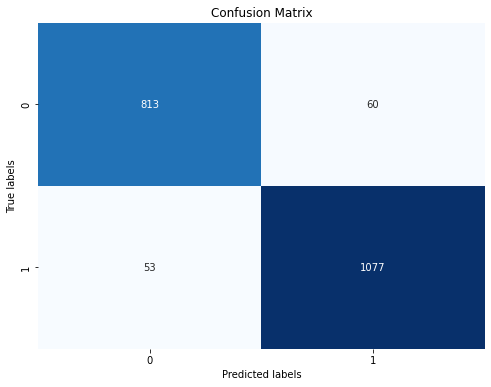

In [43]:
conf_matrix = confusion_matrix(y_test, y_pred_b5)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy Comparison

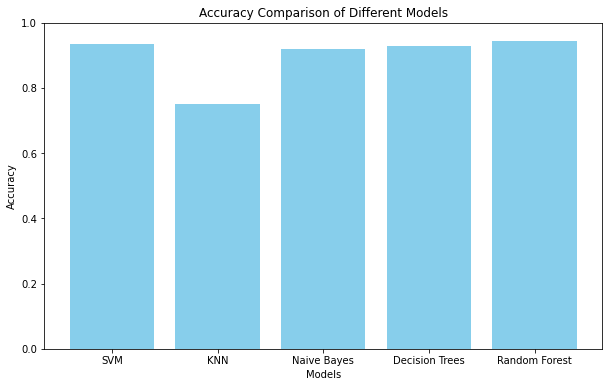

In [44]:
accuracies = [accuracy_b1, accuracy_b2, accuracy_b3, accuracy_b4, accuracy_b5]
model_names = ['SVM', 'KNN', 'Naive Bayes', 'Decision Trees', 'Random Forest']

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.show()

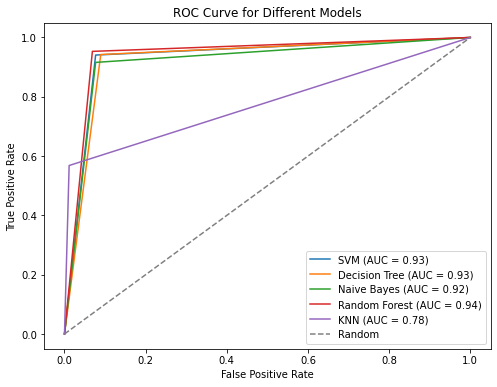

In [45]:
# Calculate ROC curve and AUC for each model

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_b1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_b4)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_b3)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_b5)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_b2)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend()
plt.show()

---

<b>Using TF-IDF</b>

In [46]:
x_tfidf = encoding(data["cleaned_tweet"],bow=False,tf_idf=True)

c:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(x_tfidf, y_final, test_size=0.2, random_state=42, stratify = y_final)

1. SVM

In [48]:
svm_tfidf = SVC(kernel='linear')
svm_tfidf.fit(X_train, y_train)
y_pred_t1 = svm_tfidf.predict(X_test)

In [49]:
accuracy_t1 = accuracy_score(y_test, y_pred_t1)
print(f"Accuracy: {accuracy_t1:.2f}")

Accuracy: 0.94


In [50]:
report = classification_report(y_test, y_pred_t1)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       873
           1       0.95      0.94      0.95      1130

    accuracy                           0.94      2003
   macro avg       0.94      0.94      0.94      2003
weighted avg       0.94      0.94      0.94      2003



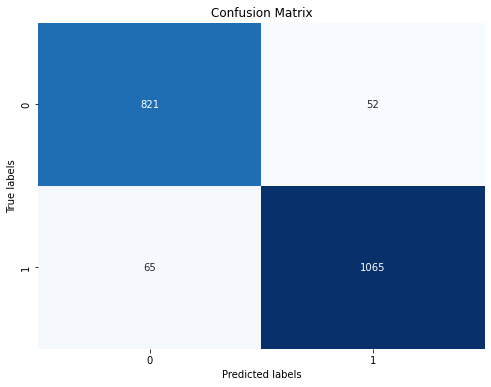

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred_t1)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

2. KNN

In [52]:
knn_tfidf = KNeighborsClassifier(n_neighbors=40)
knn_tfidf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=40)

In [53]:
y_pred_t2 = knn_tfidf.predict(X_test)

c:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [54]:
accuracy_t2 = accuracy_score(y_test, y_pred_t2)
print(f"Accuracy: {accuracy_t2:.2f}")

Accuracy: 0.85


In [55]:
report = classification_report(y_test, y_pred_t2)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       873
           1       0.89      0.84      0.86      1130

    accuracy                           0.85      2003
   macro avg       0.85      0.85      0.85      2003
weighted avg       0.85      0.85      0.85      2003



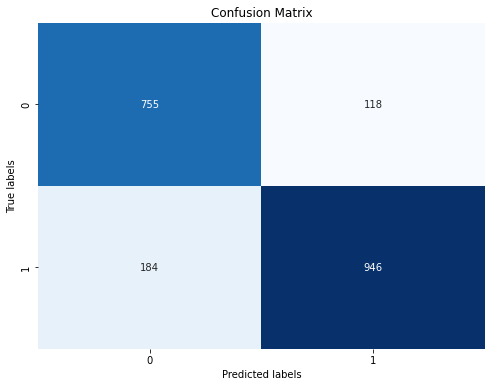

In [56]:
conf_matrix = confusion_matrix(y_test, y_pred_t2)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

3. Naive Bayes

In [57]:
nb_tfidf = BernoulliNB()
nb_tfidf.fit(X_train, y_train)

BernoulliNB()

In [58]:
y_pred_t3 = nb_tfidf.predict(X_test)

In [59]:
accuracy_t3 = accuracy_score(y_test, y_pred_t3)
print(f"Accuracy: {accuracy_t3:.2f}")

Accuracy: 0.92


In [60]:
report = classification_report(y_test, y_pred_t3)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       873
           1       0.94      0.92      0.93      1130

    accuracy                           0.92      2003
   macro avg       0.92      0.92      0.92      2003
weighted avg       0.92      0.92      0.92      2003



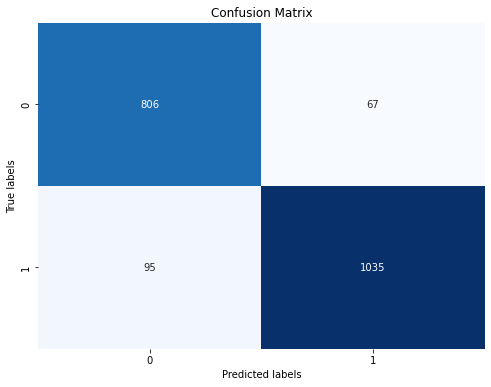

In [61]:
conf_matrix = confusion_matrix(y_test, y_pred_t3)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

4. Decision Trees

In [62]:
tree_tfidf = DecisionTreeClassifier()
tree_tfidf.fit(X_train, y_train)

DecisionTreeClassifier()

In [63]:
y_pred_t4 = tree_tfidf.predict(X_test)

In [64]:
accuracy_t4 = accuracy_score(y_test, y_pred_t4)
print(f"Accuracy: {accuracy_t4:.2f}")

Accuracy: 0.92


In [65]:
report = classification_report(y_test, y_pred_t4)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       873
           1       0.93      0.94      0.93      1130

    accuracy                           0.92      2003
   macro avg       0.92      0.92      0.92      2003
weighted avg       0.92      0.92      0.92      2003



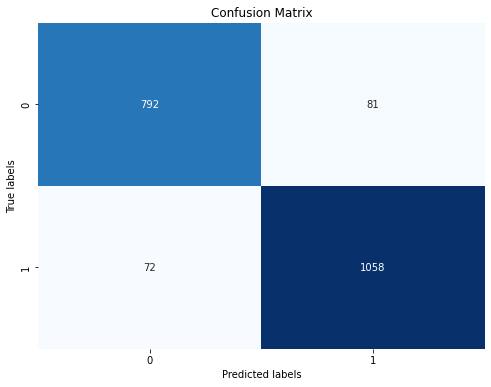

In [66]:
conf_matrix = confusion_matrix(y_test, y_pred_t4)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

5. Random Forest

In [67]:
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_train, y_train)

RandomForestClassifier()

In [68]:
y_pred_t5 = rf_tfidf.predict(X_test)

In [69]:
accuracy_t5 = accuracy_score(y_test, y_pred_t5)
print(f"Accuracy: {accuracy_t5:.2f}")

Accuracy: 0.94


In [70]:
report = classification_report(y_test, y_pred_t5)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       873
           1       0.94      0.96      0.95      1130

    accuracy                           0.94      2003
   macro avg       0.94      0.94      0.94      2003
weighted avg       0.94      0.94      0.94      2003



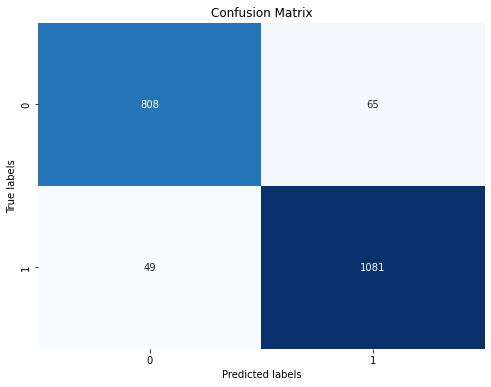

In [71]:
conf_matrix = confusion_matrix(y_test, y_pred_t5)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

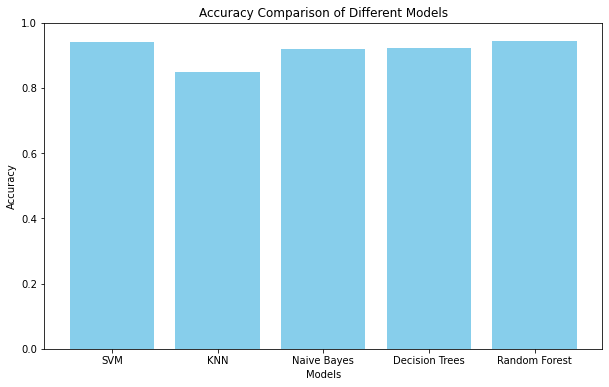

In [72]:
accuracies = [accuracy_t1, accuracy_t2, accuracy_t3, accuracy_t4, accuracy_t5]
model_names = ['SVM', 'KNN', 'Naive Bayes', 'Decision Trees', 'Random Forest']

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.show()

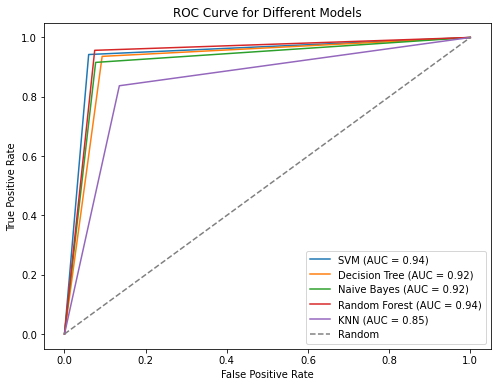

In [73]:
# Calculate ROC curve and AUC for each model

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_t1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_t4)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_t3)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_t5)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_t2)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend()
plt.show()

<b>Word Embedding Techniques</b>
1. Word2Vec

In [74]:
model_file_path = 'GoogleNews-vectors-negative300.bin.gz'

In [75]:
model = KeyedVectors.load_word2vec_format(model_file_path, binary=True)

In [76]:
vectorized_data = []
for text in data['cleaned_tweet']:
    words = text.split()  # Tokenize the preprocessed text
    sentence_vectors = [model[word] for word in words if word in model]
    vectorized_data.append(sentence_vectors)

In [77]:
max_length = max(len(sentence) for sentence in vectorized_data)

In [78]:
padded_data = np.zeros((len(vectorized_data), max_length, vectorized_data[0][0].shape[0]))

# Fill the padded_data array with the word vectors
for i, sentence_vectors in enumerate(vectorized_data):
    for j, word_vector in enumerate(sentence_vectors):
        padded_data[i][j] = word_vector

In [79]:
X_w2v = padded_data.reshape(len(padded_data), -1)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y_final, test_size=0.2, random_state=42, stratify=y_final)

1. SVM

In [81]:
svm_w2v = SVC(kernel='linear')
svm_w2v.fit(X_train, y_train)

SVC(kernel='linear')

In [82]:
y_pred_w1 = svm_w2v.predict(X_test)

In [83]:
accuracy_w1 = accuracy_score(y_test, y_pred_w1)
print(f"Accuracy: {accuracy_w1:.2f}")

Accuracy: 0.85


In [84]:
report = classification_report(y_test, y_pred_w1)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       873
           1       0.87      0.86      0.87      1130

    accuracy                           0.85      2003
   macro avg       0.85      0.85      0.85      2003
weighted avg       0.85      0.85      0.85      2003



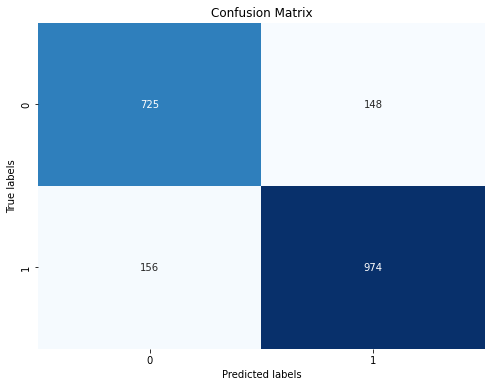

In [85]:
conf_matrix = confusion_matrix(y_test, y_pred_w1)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

2. KNN

In [86]:
knn_w2v = KNeighborsClassifier(n_neighbors=40)
knn_w2v.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=40)

In [87]:
y_pred_w2 = knn_w2v.predict(X_test)

c:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [88]:
accuracy_w2 = accuracy_score(y_test, y_pred_w2)
print(f"Accuracy: {accuracy_w2:.2f}")

Accuracy: 0.73


In [89]:
report = classification_report(y_test, y_pred_w2)
print(report)

              precision    recall  f1-score   support

           0       0.62      0.97      0.76       873
           1       0.96      0.55      0.70      1130

    accuracy                           0.73      2003
   macro avg       0.79      0.76      0.73      2003
weighted avg       0.81      0.73      0.73      2003



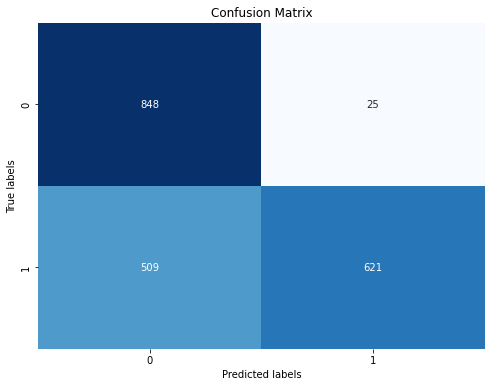

In [90]:
conf_matrix = confusion_matrix(y_test, y_pred_w2)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

3. Naive Bayes

In [91]:
nb_w2v = BernoulliNB()
nb_w2v.fit(X_train, y_train)

BernoulliNB()

In [92]:
y_pred_w3 = nb_w2v.predict(X_test)

In [93]:
accuracy_w3 = accuracy_score(y_test, y_pred_w3)
print(f"Accuracy: {accuracy_w3:.2f}")

Accuracy: 0.67


In [94]:
report = classification_report(y_test, y_pred_w3)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.74      0.66       873
           1       0.75      0.62      0.68      1130

    accuracy                           0.67      2003
   macro avg       0.67      0.68      0.67      2003
weighted avg       0.68      0.67      0.67      2003



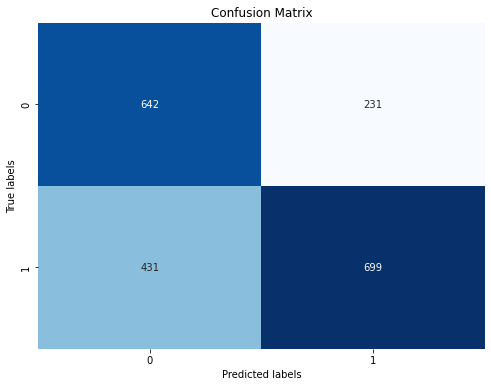

In [95]:
conf_matrix = confusion_matrix(y_test, y_pred_w3)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

4. Decision Trees

In [96]:
tree_w2v = DecisionTreeClassifier()
tree_w2v.fit(X_train, y_train)

DecisionTreeClassifier()

In [97]:
y_pred_w4 = tree_w2v.predict(X_test)

In [98]:
accuracy_w4 = accuracy_score(y_test, y_pred_w4)
print(f"Accuracy: {accuracy_w4:.2f}")

Accuracy: 0.78


In [99]:
report = classification_report(y_test, y_pred_w4)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       873
           1       0.79      0.82      0.81      1130

    accuracy                           0.78      2003
   macro avg       0.78      0.77      0.77      2003
weighted avg       0.78      0.78      0.78      2003



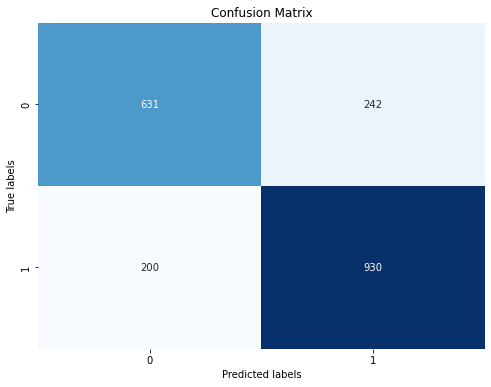

In [100]:
conf_matrix = confusion_matrix(y_test, y_pred_w4)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

5. Random Forest

In [101]:
rf_w2v = RandomForestClassifier()
rf_w2v.fit(X_train, y_train)

RandomForestClassifier()

In [102]:
y_pred_w5 = rf_w2v.predict(X_test)

In [103]:
accuracy_w5 = accuracy_score(y_test, y_pred_w5)
print(f"Accuracy: {accuracy_w5:.2f}")

Accuracy: 0.86


In [104]:
report = classification_report(y_test, y_pred_w5)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       873
           1       0.88      0.88      0.88      1130

    accuracy                           0.86      2003
   macro avg       0.86      0.86      0.86      2003
weighted avg       0.86      0.86      0.86      2003



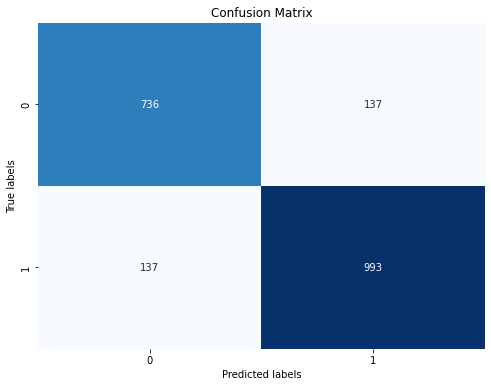

In [105]:
conf_matrix = confusion_matrix(y_test, y_pred_w5)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

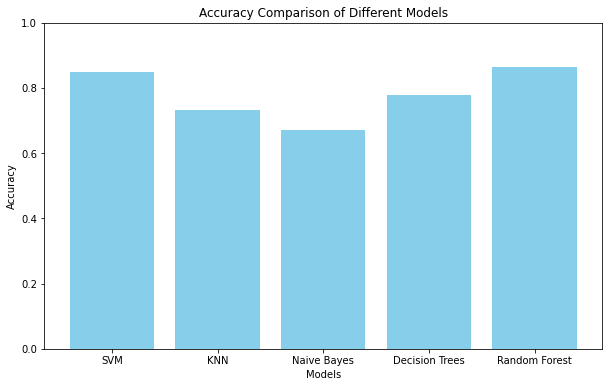

In [106]:
accuracies = [accuracy_w1, accuracy_w2, accuracy_w3, accuracy_w4, accuracy_w5]
model_names = ['SVM', 'KNN', 'Naive Bayes', 'Decision Trees', 'Random Forest']

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.show()

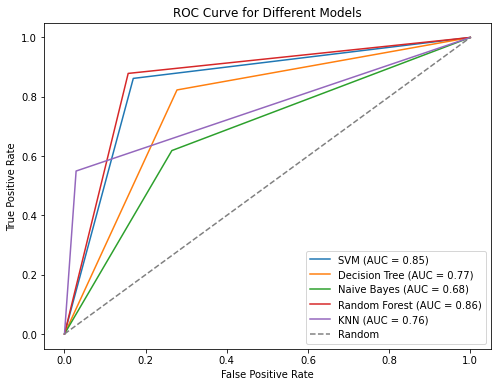

In [107]:
# Calculate ROC curve and AUC for each model

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_w1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_w4)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_w3)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_w5)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_w2)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plotting ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend()
plt.show()

<b>Combining the different word vectorization techniques</b>

##### 1. All 3 techniques

In [108]:
combined_features_1 = np.concatenate((x_bow, x_tfidf, X_w2v), axis=1)

In [109]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(combined_features_1, y_final, test_size=0.2, random_state=42, stratify = y_final)

Random Forest

In [110]:
rf_btw = RandomForestClassifier()
rf_btw.fit(X_train_1, y_train_1)

RandomForestClassifier()

In [111]:
y_pred_rf1 = rf_btw.predict(X_test_1)

In [112]:
accuracy_btw1 = accuracy_score(y_test_1, y_pred_rf1)
print(f"Accuracy: {accuracy_btw1:.2f}")

Accuracy: 0.90


In [113]:
report = classification_report(y_test, y_pred_rf1)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       873
           1       0.91      0.91      0.91      1130

    accuracy                           0.90      2003
   macro avg       0.89      0.89      0.89      2003
weighted avg       0.90      0.90      0.90      2003



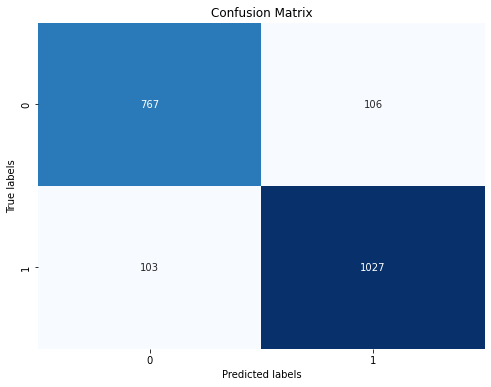

In [114]:
conf_matrix = confusion_matrix(y_test, y_pred_rf1)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

SVM

In [115]:
svm_btw = SVC(kernel='linear')
svm_btw.fit(X_train_1, y_train_1)

SVC(kernel='linear')

In [116]:
y_pred_s1 = svm_btw.predict(X_test_1)

In [117]:
accuracy_btw2 = accuracy_score(y_test_1, y_pred_s1)
print(f"Accuracy: {accuracy_btw2:.2f}")

Accuracy: 0.91


In [118]:
report = classification_report(y_test, y_pred_s1)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       873
           1       0.92      0.92      0.92      1130

    accuracy                           0.91      2003
   macro avg       0.91      0.91      0.91      2003
weighted avg       0.91      0.91      0.91      2003



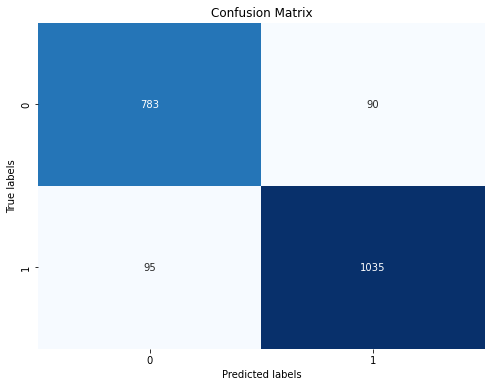

In [119]:
conf_matrix = confusion_matrix(y_test, y_pred_s1)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

KNN

In [120]:
knn_btw = KNeighborsClassifier(n_neighbors=40)
knn_btw.fit(X_train_1, y_train_1)

KNeighborsClassifier(n_neighbors=40)

In [121]:
y_pred_k1 = knn_btw.predict(X_test_1)

c:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [122]:
accuracy_btw3 = accuracy_score(y_test_1, y_pred_k1)
print(f"Accuracy: {accuracy_btw3:.2f}")

Accuracy: 0.71


In [123]:
report = classification_report(y_test, y_pred_k1)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.99      0.75       873
           1       0.98      0.50      0.66      1130

    accuracy                           0.71      2003
   macro avg       0.79      0.74      0.71      2003
weighted avg       0.82      0.71      0.70      2003



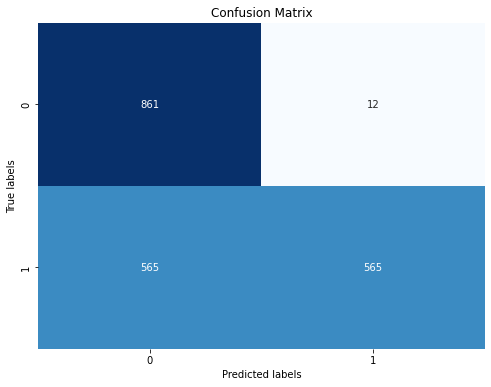

In [124]:
conf_matrix = confusion_matrix(y_test, y_pred_k1)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Naive Bayes

In [125]:
nb_btw = BernoulliNB()
nb_btw.fit(X_train_1, y_train_1)

BernoulliNB()

In [126]:
y_pred_n1 = nb_btw.predict(X_test_1)

In [127]:
accuracy_btw4 = accuracy_score(y_test_1, y_pred_n1)
print(f"Accuracy: {accuracy_btw4:.2f}")

Accuracy: 0.68


In [128]:
report = classification_report(y_test, y_pred_n1)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.75      0.67       873
           1       0.77      0.63      0.69      1130

    accuracy                           0.68      2003
   macro avg       0.69      0.69      0.68      2003
weighted avg       0.70      0.68      0.68      2003



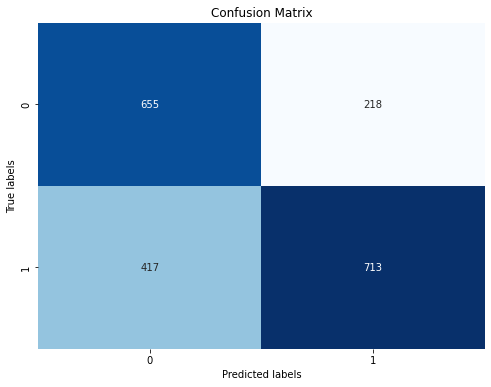

In [129]:
conf_matrix = confusion_matrix(y_test, y_pred_n1)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Decision Trees

In [130]:
tree_btw = DecisionTreeClassifier()
tree_btw.fit(X_train_1, y_train_1)

DecisionTreeClassifier()

In [131]:
y_pred_d1 = tree_btw.predict(X_test_1)

In [132]:
accuracy_btw5 = accuracy_score(y_test_1, y_pred_d1)
print(f"Accuracy: {accuracy_btw5:.2f}")

Accuracy: 0.90


In [133]:
report = classification_report(y_test, y_pred_d1)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       873
           1       0.92      0.91      0.91      1130

    accuracy                           0.90      2003
   macro avg       0.90      0.90      0.90      2003
weighted avg       0.90      0.90      0.90      2003



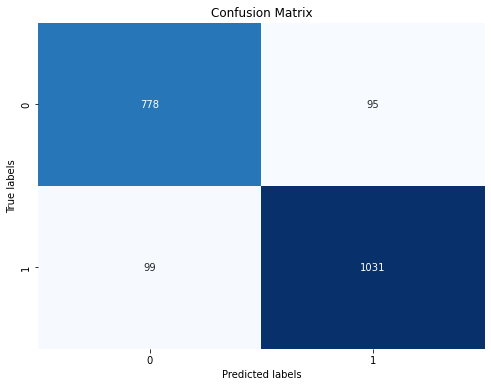

In [134]:
conf_matrix = confusion_matrix(y_test, y_pred_d1)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##### 2. BoW and Word2Vec

In [135]:
combined_features_2 = np.concatenate((x_bow, X_w2v), axis=1)

In [136]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(combined_features_2, y_final, test_size=0.2, random_state=42, stratify = y_final)

Random Forest

In [137]:
rf_bw = RandomForestClassifier()
rf_bw.fit(X_train_2, y_train_2)

RandomForestClassifier()

In [138]:
y_pred_rf2 = rf_bw.predict(X_test_2)

In [139]:
accuracy_bw1 = accuracy_score(y_test_2, y_pred_rf2)
print(f"Accuracy: {accuracy_bw1:.2f}")

Accuracy: 0.87


In [140]:
report = classification_report(y_test, y_pred_rf2)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       873
           1       0.89      0.88      0.89      1130

    accuracy                           0.87      2003
   macro avg       0.87      0.87      0.87      2003
weighted avg       0.87      0.87      0.87      2003



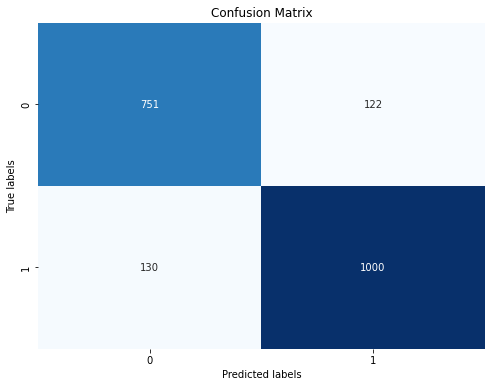

In [141]:
conf_matrix = confusion_matrix(y_test, y_pred_rf2)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

SVM

In [142]:
svm_bw = SVC(kernel='linear')
svm_bw.fit(X_train_2, y_train_2)

SVC(kernel='linear')

In [143]:
y_pred_s2 = svm_bw.predict(X_test_2)

In [144]:
accuracy_bw2 = accuracy_score(y_test_2, y_pred_s2)
print(f"Accuracy: {accuracy_bw2:.2f}")

Accuracy: 0.91


In [145]:
report = classification_report(y_test, y_pred_s2)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       873
           1       0.92      0.91      0.92      1130

    accuracy                           0.91      2003
   macro avg       0.90      0.90      0.90      2003
weighted avg       0.91      0.91      0.91      2003



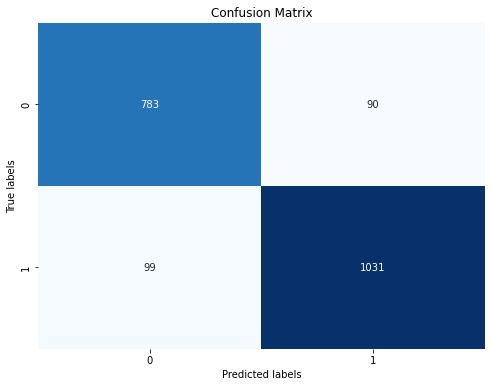

In [146]:
conf_matrix = confusion_matrix(y_test, y_pred_s2)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

KNN

In [147]:
knn_bw = KNeighborsClassifier(n_neighbors=40)
knn_bw.fit(X_train_2, y_train_2)

KNeighborsClassifier(n_neighbors=40)

In [148]:
y_pred_k2 = knn_bw.predict(X_test_2)

c:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [149]:
accuracy_bw3 = accuracy_score(y_test_2, y_pred_k2)
print(f"Accuracy: {accuracy_bw3:.2f}")

Accuracy: 0.71


In [150]:
report = classification_report(y_test, y_pred_k2)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.99      0.75       873
           1       0.98      0.51      0.67      1130

    accuracy                           0.71      2003
   macro avg       0.79      0.75      0.71      2003
weighted avg       0.82      0.71      0.70      2003



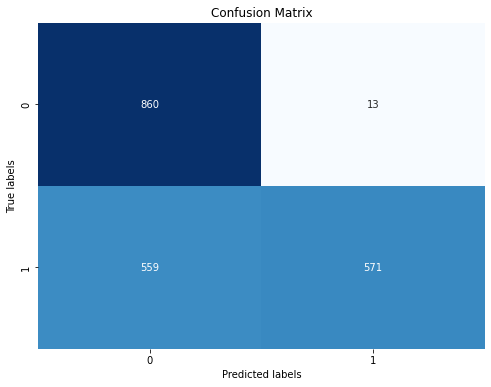

In [151]:
conf_matrix = confusion_matrix(y_test, y_pred_k2)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Naive Bayes

In [152]:
nb_bw = BernoulliNB()
nb_bw.fit(X_train_2, y_train_2)

BernoulliNB()

In [153]:
y_pred_n2 = nb_bw.predict(X_test_2)

In [154]:
accuracy_bw4 = accuracy_score(y_test_2, y_pred_n2)
print(f"Accuracy: {accuracy_bw4:.2f}")

Accuracy: 0.67


In [155]:
report = classification_report(y_test, y_pred_n2)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.74      0.67       873
           1       0.76      0.62      0.68      1130

    accuracy                           0.67      2003
   macro avg       0.68      0.68      0.67      2003
weighted avg       0.69      0.67      0.67      2003



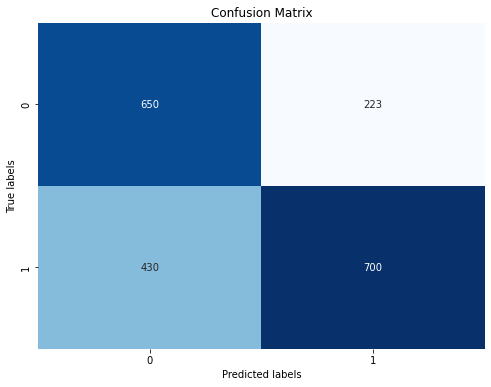

In [156]:
conf_matrix = confusion_matrix(y_test, y_pred_n2)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Decision Trees

In [157]:
tree_bw = DecisionTreeClassifier()
tree_bw.fit(X_train_2, y_train_2)

DecisionTreeClassifier()

In [158]:
y_pred_d2 = tree_bw.predict(X_test_2)

In [159]:
accuracy_bw5 = accuracy_score(y_test_2, y_pred_d2)
print(f"Accuracy: {accuracy_bw5:.2f}")

Accuracy: 0.90


In [160]:
report = classification_report(y_test, y_pred_d2)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       873
           1       0.91      0.92      0.91      1130

    accuracy                           0.90      2003
   macro avg       0.90      0.90      0.90      2003
weighted avg       0.90      0.90      0.90      2003



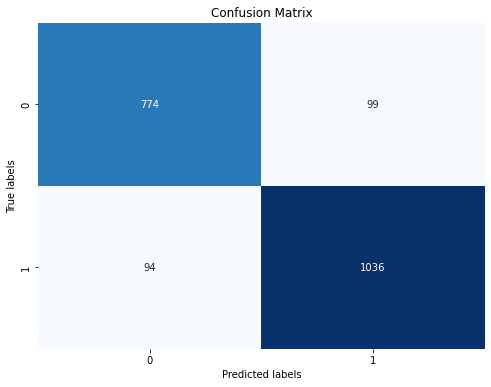

In [161]:
conf_matrix = confusion_matrix(y_test, y_pred_d2)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##### 3. TFIDF + Word2Vec

In [162]:
combined_features_3 = np.concatenate((x_tfidf, X_w2v), axis=1)

In [163]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(combined_features_3, y_final, test_size=0.2, random_state=42, stratify = y_final)

Random Forest

In [164]:
rf_tw = RandomForestClassifier()
rf_tw.fit(X_train_3, y_train_3)

RandomForestClassifier()

In [165]:
y_pred_rf3 = rf_tw.predict(X_test_3)

In [166]:
accuracy_tw1 = accuracy_score(y_test_3, y_pred_rf3)
print(f"Accuracy: {accuracy_tw1:.2f}")

Accuracy: 0.88


In [167]:
report = classification_report(y_test, y_pred_rf3)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       873
           1       0.89      0.89      0.89      1130

    accuracy                           0.88      2003
   macro avg       0.87      0.87      0.87      2003
weighted avg       0.88      0.88      0.88      2003



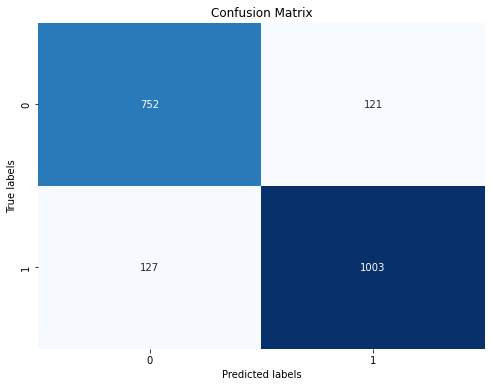

In [168]:
conf_matrix = confusion_matrix(y_test, y_pred_rf3)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

SVM

In [169]:
svm_tw = SVC(kernel='linear')
svm_tw.fit(X_train_3, y_train_3)

SVC(kernel='linear')

In [170]:
y_pred_s3 = svm_tw.predict(X_test_3)

In [171]:
accuracy_tw2 = accuracy_score(y_test_3, y_pred_s3)
print(f"Accuracy: {accuracy_tw2:.2f}")

Accuracy: 0.89


In [172]:
report = classification_report(y_test, y_pred_s3)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       873
           1       0.90      0.90      0.90      1130

    accuracy                           0.89      2003
   macro avg       0.88      0.88      0.88      2003
weighted avg       0.89      0.89      0.89      2003



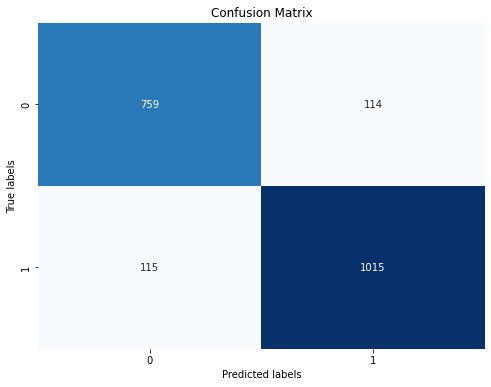

In [173]:
conf_matrix = confusion_matrix(y_test, y_pred_s3)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

KNN

In [174]:
knn_tw = KNeighborsClassifier(n_neighbors=40)
knn_tw.fit(X_train_3, y_train_3)

KNeighborsClassifier(n_neighbors=40)

In [175]:
y_pred_k3 = knn_tw.predict(X_test_3)

c:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [176]:
accuracy_tw3 = accuracy_score(y_test_3, y_pred_k3)
print(f"Accuracy: {accuracy_tw3:.2f}")

Accuracy: 0.73


In [177]:
report = classification_report(y_test, y_pred_k3)
print(report)

              precision    recall  f1-score   support

           0       0.62      0.97      0.76       873
           1       0.96      0.55      0.70      1130

    accuracy                           0.73      2003
   macro avg       0.79      0.76      0.73      2003
weighted avg       0.81      0.73      0.72      2003



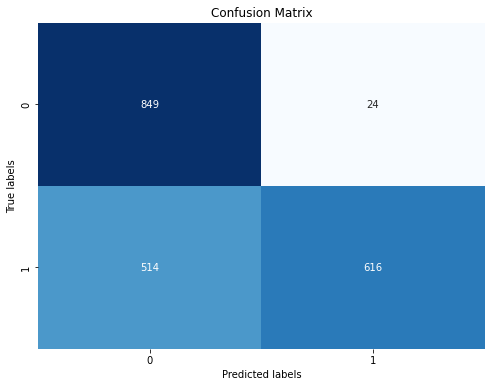

In [178]:
conf_matrix = confusion_matrix(y_test, y_pred_k3)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Naive Bayes

In [179]:
nb_tw = BernoulliNB()
nb_tw.fit(X_train_3, y_train_3)

BernoulliNB()

In [180]:
y_pred_n3 = nb_tw.predict(X_test_3)

In [181]:
accuracy_tw4 = accuracy_score(y_test_3, y_pred_n3)
print(f"Accuracy: {accuracy_tw4:.2f}")

Accuracy: 0.67


In [182]:
report = classification_report(y_test, y_pred_n3)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.74      0.67       873
           1       0.76      0.62      0.68      1130

    accuracy                           0.67      2003
   macro avg       0.68      0.68      0.67      2003
weighted avg       0.69      0.67      0.67      2003



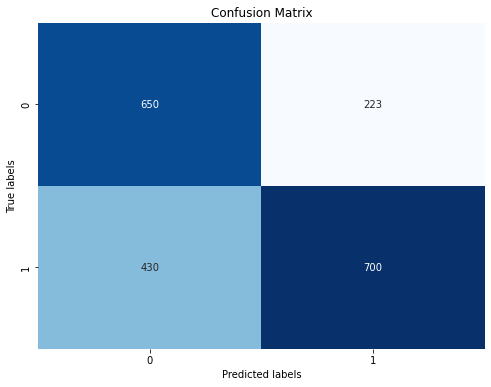

In [183]:
conf_matrix = confusion_matrix(y_test, y_pred_n3)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Decision Trees

In [184]:
tree_tw = DecisionTreeClassifier()
tree_tw.fit(X_train_3, y_train_3)

DecisionTreeClassifier()

In [185]:
y_pred_d3 = tree_tw.predict(X_test_3)

In [186]:
accuracy_tw5 = accuracy_score(y_test_3, y_pred_d3)
print(f"Accuracy: {accuracy_tw5:.2f}")

Accuracy: 0.91


In [187]:
report = classification_report(y_test, y_pred_d3)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       873
           1       0.92      0.92      0.92      1130

    accuracy                           0.91      2003
   macro avg       0.91      0.91      0.91      2003
weighted avg       0.91      0.91      0.91      2003



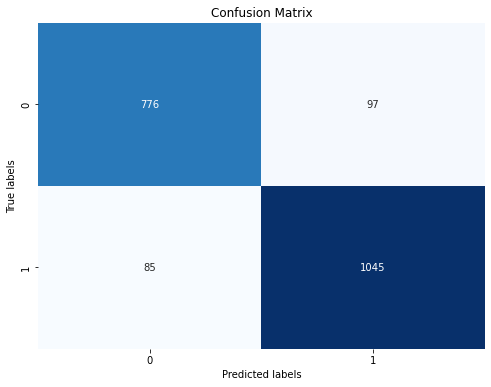

In [188]:
conf_matrix = confusion_matrix(y_test, y_pred_d3)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##### 4. BoW + TFIDF

In [189]:
combined_features_4 = np.concatenate((x_bow, x_tfidf), axis=1)

In [190]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(combined_features_4, y_final, test_size=0.2, random_state=42, stratify = y_final)

Random Forest

In [191]:
rf_bt = RandomForestClassifier()
rf_bt.fit(X_train_4, y_train_4)

RandomForestClassifier()

In [192]:
y_pred_rf4 = rf_bt.predict(X_test_4)

In [193]:
accuracy_bt1 = accuracy_score(y_test_4, y_pred_rf4)
print(f"Accuracy: {accuracy_bt1:.2f}")

Accuracy: 0.94


In [194]:
report = classification_report(y_test, y_pred_rf4)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       873
           1       0.94      0.95      0.95      1130

    accuracy                           0.94      2003
   macro avg       0.94      0.94      0.94      2003
weighted avg       0.94      0.94      0.94      2003



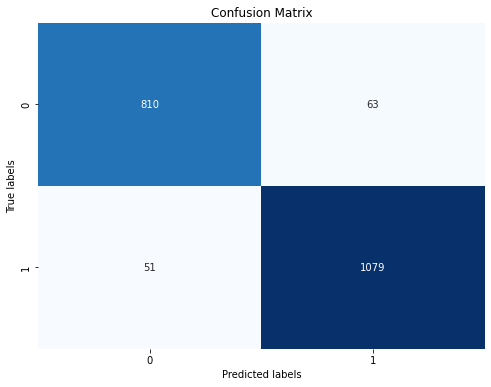

In [195]:
conf_matrix = confusion_matrix(y_test, y_pred_rf4)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

SVM

In [196]:
svm_bt = SVC(kernel='linear')
svm_bt.fit(X_train_4, y_train_4)

SVC(kernel='linear')

In [197]:
y_pred_s4 = svm_bt.predict(X_test_4)

In [198]:
accuracy_bt2 = accuracy_score(y_test_4, y_pred_s4)
print(f"Accuracy: {accuracy_bt2:.2f}")

Accuracy: 0.93


In [199]:
report = classification_report(y_test, y_pred_s4)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       873
           1       0.94      0.94      0.94      1130

    accuracy                           0.93      2003
   macro avg       0.93      0.93      0.93      2003
weighted avg       0.93      0.93      0.93      2003



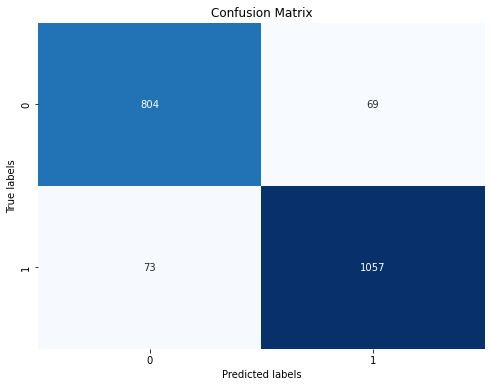

In [200]:
conf_matrix = confusion_matrix(y_test, y_pred_s4)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

KNN

In [201]:
knn_bt = KNeighborsClassifier(n_neighbors=40)
knn_bt.fit(X_train_4, y_train_4)

KNeighborsClassifier(n_neighbors=40)

In [202]:
y_pred_k4 = knn_bt.predict(X_test_4)

c:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [203]:
accuracy_bt3 = accuracy_score(y_test_4, y_pred_k4)
print(f"Accuracy: {accuracy_bt3:.2f}")

Accuracy: 0.81


In [204]:
report = classification_report(y_test, y_pred_k4)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.97      0.82       873
           1       0.97      0.69      0.80      1130

    accuracy                           0.81      2003
   macro avg       0.84      0.83      0.81      2003
weighted avg       0.86      0.81      0.81      2003



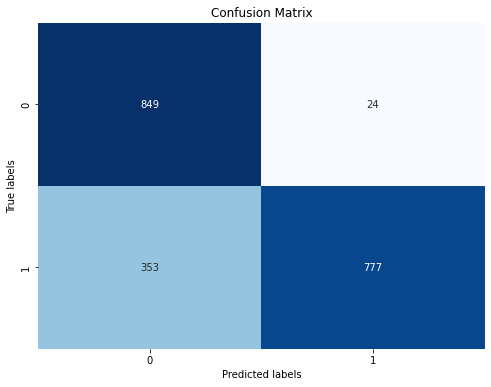

In [205]:
conf_matrix = confusion_matrix(y_test, y_pred_k4)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Naive Bayes

In [206]:
nb_bt = BernoulliNB()
nb_bt.fit(X_train_4, y_train_4)

BernoulliNB()

In [207]:
y_pred_n4 = nb_bt.predict(X_test_4)

In [208]:
accuracy_bt4 = accuracy_score(y_test_4, y_pred_n4)
print(f"Accuracy: {accuracy_bt4:.2f}")

Accuracy: 0.92


In [209]:
report = classification_report(y_test, y_pred_n4)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       873
           1       0.94      0.91      0.93      1130

    accuracy                           0.92      2003
   macro avg       0.91      0.92      0.92      2003
weighted avg       0.92      0.92      0.92      2003



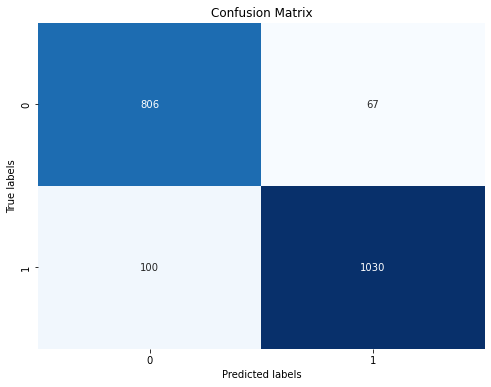

In [210]:
conf_matrix = confusion_matrix(y_test, y_pred_n4)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Decision Trees

In [211]:
tree_bt = DecisionTreeClassifier()
tree_bt.fit(X_train_4, y_train_4)

DecisionTreeClassifier()

In [212]:
y_pred_d4 = tree_bt.predict(X_test_4)

In [213]:
accuracy_bt5 = accuracy_score(y_test_4, y_pred_d4)
print(f"Accuracy: {accuracy_bt5:.2f}")

Accuracy: 0.93


In [214]:
report = classification_report(y_test, y_pred_d4)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       873
           1       0.93      0.94      0.94      1130

    accuracy                           0.93      2003
   macro avg       0.93      0.92      0.93      2003
weighted avg       0.93      0.93      0.93      2003



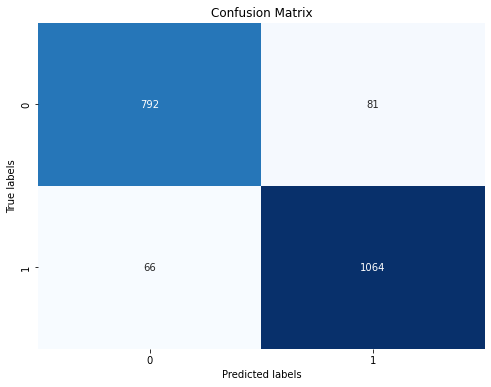

In [215]:
conf_matrix = confusion_matrix(y_test, y_pred_d4)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [216]:
X_train_1.shape,X_test_1.shape, y_train_1.shape, y_test_1.shape

((8009, 21610), (2003, 21610), (8009,), (2003,))

In [217]:
X_train_2.shape,X_test_2.shape, y_train_2.shape, y_test_2.shape

((8009, 13505), (2003, 13505), (8009,), (2003,))

Majority Voting and Average Probabilities<br> 1. SVM

In [218]:
from scipy.stats import mode

In [219]:
encoder = LabelEncoder()
y_test_1 = encoder.fit_transform(y_test_1)
y_pred_s1 = encoder.fit_transform(y_pred_s1)
y_pred_s2 = encoder.fit_transform(y_pred_s2)
y_pred_s3 = encoder.fit_transform(y_pred_s3)
y_pred_s4 = encoder.fit_transform(y_pred_s4)

In [220]:
y_pred_s1

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [221]:
true_labels = y_test_1

In [222]:
ensemble_predictions = np.array([y_pred_s1, y_pred_s2, y_pred_s3, y_pred_s4])
final_pred_majority_vote = mode(ensemble_predictions)[0][0]
accuracy_majority_vote = accuracy_score(true_labels, final_pred_majority_vote)
print('Majority Voting:', accuracy_majority_vote)

Majority Voting: 0.9101347978032951


C:\Users\hp\AppData\Local\Temp\ipykernel_39172\2274256836.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_pred_majority_vote = mode(ensemble_predictions)[0][0]


In [223]:
true_labels = y_test_1
accuracy_majority_vote = accuracy_score(true_labels, final_pred_majority_vote)
print(accuracy_majority_vote)

0.9101347978032951


2. KNN 

In [224]:
true_labels=y_test_2

In [225]:
ensemble_predictions = np.array([y_pred_k1, y_pred_k2, y_pred_k3, y_pred_k4])
final_pred_majority_vote = mode(ensemble_predictions)[0][0]
accuracy_majority_vote = accuracy_score(true_labels, final_pred_majority_vote)
print(accuracy_majority_vote)

0.7139291063404892


C:\Users\hp\AppData\Local\Temp\ipykernel_39172\2129403561.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_pred_majority_vote = mode(ensemble_predictions)[0][0]


3. Naive Bayes

In [226]:
ensemble_predictions = np.array([y_pred_n1, y_pred_n2, y_pred_n3, y_pred_n4])
final_pred_majority_vote = mode(ensemble_predictions)[0][0]
accuracy_majority_vote = accuracy_score(true_labels, final_pred_majority_vote)
print(accuracy_majority_vote)

0.6759860209685472


C:\Users\hp\AppData\Local\Temp\ipykernel_39172\2369795659.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_pred_majority_vote = mode(ensemble_predictions)[0][0]


4. Decision Trees

In [233]:
ensemble_predictions = np.array([y_pred_d1, y_pred_d2, y_pred_d3, y_pred_d4])
final_pred_majority_vote = mode(ensemble_predictions)[0][0]
accuracy_majority_vote = accuracy_score(true_labels, final_pred_majority_vote)
print(accuracy_majority_vote)

0.9201198202695956


C:\Users\hp\AppData\Local\Temp\ipykernel_21684\3475381007.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_pred_majority_vote = mode(ensemble_predictions)[0][0]


5. Random Forest

In [234]:
ensemble_predictions = np.array([y_pred_rf1, y_pred_rf2, y_pred_rf3, y_pred_rf4])
final_pred_majority_vote = mode(ensemble_predictions)[0][0]
accuracy_majority_vote = accuracy_score(true_labels, final_pred_majority_vote)
print(accuracy_majority_vote)

C:\Users\hp\AppData\Local\Temp\ipykernel_21684\1642173690.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_pred_majority_vote = mode(ensemble_predictions)[0][0]


0.8936595107338992


Visualization

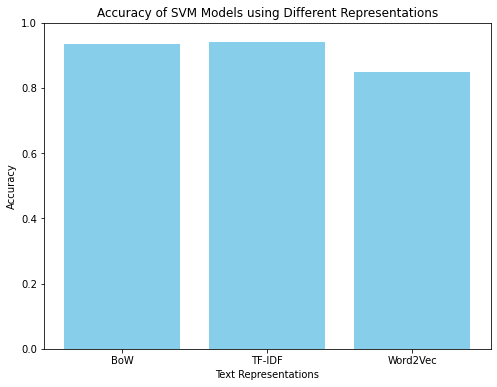

In [235]:
labels = ['BoW', 'TF-IDF', 'Word2Vec']
accuracies = [accuracy_b1, accuracy_t1, accuracy_w1]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color='skyblue')
plt.xlabel('Text Representations')
plt.ylabel('Accuracy')
plt.title('Accuracy of SVM Models using Different Representations')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.show()

In [ ]:
accuracies = [accuracy_bow, accuracy_tfidf, accuracy_word2vec]
f1_scores = [f1_bow, f1_tfidf, f1_word2vec]  # Calculate F1 scores similarly

# Plotting accuracy and F1 scores for comparison
labels = ['BoW', 'TF-IDF', 'Word2Vec']

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(labels, accuracies, color='skyblue', label='Accuracy')
ax1.set_ylabel('Accuracy', color='skyblue')
ax1.tick_params('y', colors='skyblue')

ax2 = ax1.twinx()
ax2.plot(labels, f1_scores, color='orange', marker='o', label='F1 Score')
ax2.set_ylabel('F1 Score', color='orange')
ax2.tick_params('y', colors='orange')

plt.title('Accuracy and F1 Score Comparison for SVM Models using Different Representations')
plt.legend()
plt.tight_layout()
plt.show()

<b>LSTM</b>

In [ ]:
from keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers

embedding_feature_vector = 200 # Since we used glove vector embedding of dim 200.
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=max_length,weights = [word_vector_matrix], trainable = False))
model.add(Dropout(0.35))
model.add(LSTM(200))
model.add(Dropout(0.35))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4),metrics=['accuracy'])
print(model.summary())